# Imports
---

In [1]:
#C:\Users\tjobe\Desktop\datathonDatasets
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import openpyxl

ERROR = "\033[31;1m"
CLS = "\033[0m"

# Task 1
---

#### Load Dataset 

In [5]:
# Load the dataset from a CSV file (replace 'your_data.csv' with your file's path)
data = pd.read_csv('datathonDatasets/ussd17.csv', header=0, encoding='latin-1')
#data.head()

#### Extract and Normalize Data

In [6]:
# Extract the relevant columns
total_students = data['Estimated Total Population']
students_in_poverty = data['Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder']

# =========================================================================================================================

# Normalize the data
scaler = MinMaxScaler()
cols_to_normalize = ['Estimated Total Population', 'Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder']
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])


#### Plot Data

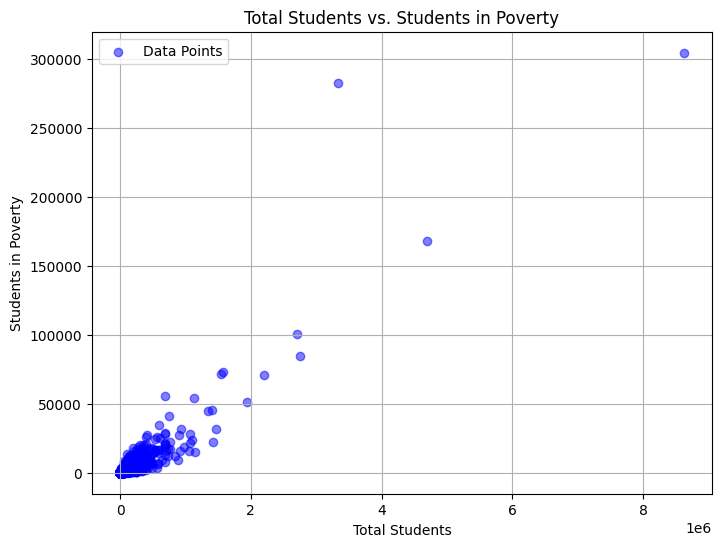

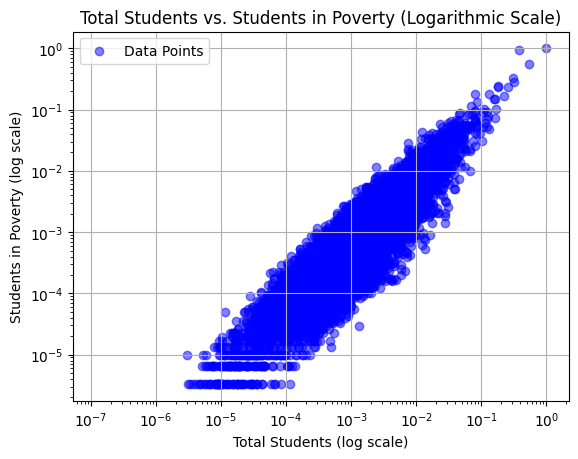

In [7]:
# Create a scatter plotp
plt.figure(figsize=(8, 6))
plt.scatter(total_students, students_in_poverty, alpha=0.5, c='blue', label='Data Points')

# Add labels and a title
plt.xlabel('Total Students')
plt.ylabel('Students in Poverty')
plt.title('Total Students vs. Students in Poverty')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

# =========================================================================================================================

# Log scale the data
plt.xscale('log')
plt.yscale('log')

# Plot the data
plt.scatter(data['Estimated Total Population'], data['Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder'], alpha=0.5, c='blue', label='Data Points')

# Add labels and a title
plt.xlabel('Total Students (log scale)')
plt.ylabel('Students in Poverty (log scale)')
plt.title('Total Students vs. Students in Poverty (Logarithmic Scale)')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

##### Plot Texas Data

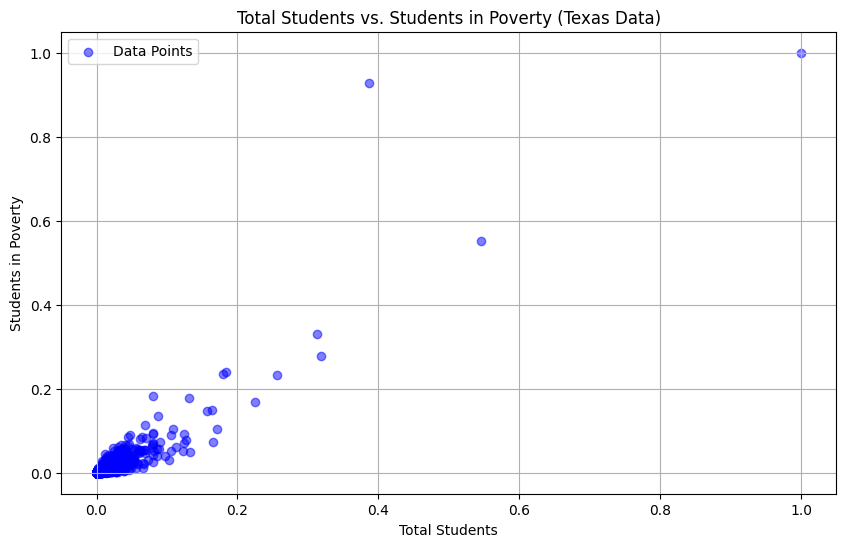

In [8]:
# Filter the data to select only Texas data (FIPS code 48)
texas_data = data[data['State FIPS Code'] == 48]

# Create a scatter plot for the Texas data
plt.figure(figsize=(10, 6))
plt.scatter(data['Estimated Total Population'], data['Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder'], alpha=0.5, c='blue', label='Data Points')

# Add labels and a title
plt.xlabel('Total Students')
plt.ylabel('Students in Poverty')
plt.title('Total Students vs. Students in Poverty (Texas Data)')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

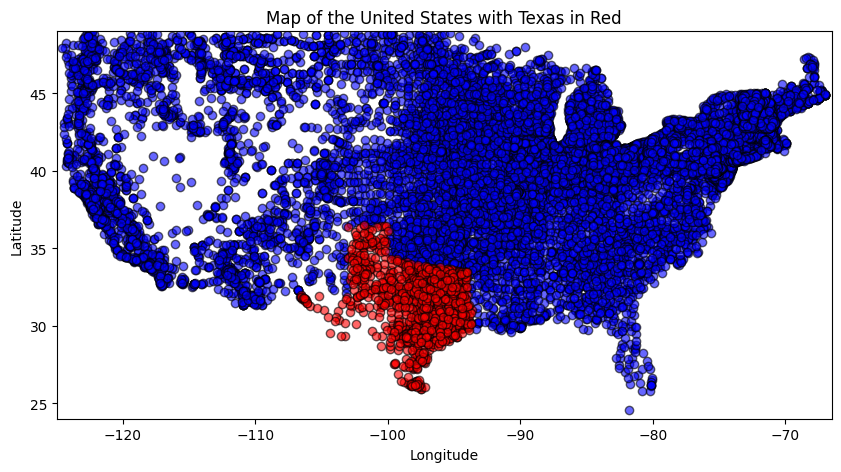

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
gdf = gpd.read_file('datathonDatasets/EDGE_GEOCODE_PUBLICLEA_1718/EDGE_GEOCODE_PUBLICLEA_1718.shp')

# Filter the data for Texas (state code 'TX')
texas_data = gdf[gdf['STATE'] == 'TX']

# Filter the data for other states
other_states_data = gdf[gdf['STATE'] != 'TX']

# Create a map with a bounding box for the United States
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define the bounding box for the United States
usa_bbox = (-125, -66.5, 24, 49)  # (left, right, bottom, top)

# Set the map extent to the bounding box
ax.set_xlim(usa_bbox[0], usa_bbox[1])
ax.set_ylim(usa_bbox[2], usa_bbox[3])

# Plot the geospatial data for other states in one color
other_states_data.plot(ax=ax, color='blue', alpha=0.6, edgecolor='k', label='Other States')

# Plot the geospatial data for Texas in a different color
texas_data.plot(ax=ax, color='red', alpha=0.6, edgecolor='k', label='Texas')

# Add a title and labels
ax.set_title('Map of the United States with Texas in Red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the map
plt.show()

# Task 2
---

#### Connect to DB

In [10]:
#connect to the database
conn = None
def connect():
    global conn
    try:
        conn = psycopg2.connect(database = "Datathon2023",
                            host = "localhost",
                            user ="postgres",
                            password ="irish4340",
                            port = "5432")
    except PermissionError:
        print(f"{ERROR}DATASET PERMISSION DENIED{CLS}")
        exit(1)

    if conn == None:
        print(f"{ERROR}CONNECTION ERROR{CLS}")
        exit(1)
connect()

#### Execute Commands Function
\**for cleaner code*\*

In [11]:
def exec_query(query:str) -> list[str]:
    try:
        cursor = conn.cursor()
        cursor.execute(query) # this is for executing query commands for accessing the data
        return cursor.fetchall()
    except Exception as e:
        if e.args == ('current transaction is aborted, commands ignored until end of transaction block\n',):
            print(f"{ERROR}ERROR: CLEAR BUFER{CLS}")
            connect()
            return None
        print(f"{ERROR}ERROR: {e.args[0].strip()}{CLS}")
        return None


# Task 3
---

#### Create a dictionary of different ISDs correlated to a Tract
dict: tract -> LEA[]

In [12]:
# tract_to_LEAID = {}
# for row in worksheet.iter_rows(min_row=1, values_only=True):
#     if tract_to_LEAID.get(row[2]) == None:
#         tract_to_LEAID.update({row[2]:[row[0]]})
#     elif not row[0] in tract_to_LEAID.get(row[2]):
#         tract_to_LEAID.get(row[2]).append(row[0])

NameError: name 'worksheet' is not defined

#### Grabbing Approvals for Texas

In [ ]:
approvals = None
# this is for executing query commands for accessing the data
approvals = exec_query("WITH grf AS(\
                           SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                           FROM grf17_tracks\
                        ),\
                        hdma AS (\
                           SELECT\
                              CASE \
                              WHEN COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END) > 0\
                              THEN (COUNT(CASE WHEN action_taken IN ('1', '2', '8') THEN 1 END) * 100.0 / COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END))::DOUBLE PRECISION\
                              ELSE 0\
                           END as percentage_accepted,\
                           (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                           FROM all_hdma_2017\
                           WHERE state_abbr = 'TX'\
                           GROUP BY census_track_num\
                        )\
                        SELECT avg(hdma.percentage_accepted) as Percent_Accepted, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                        FROM hdma\
                        JOIN grf ON grf.tract = hdma.census_track_num\
                        JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                        GROUP BY grf.name_lea17, grf.leaid;")

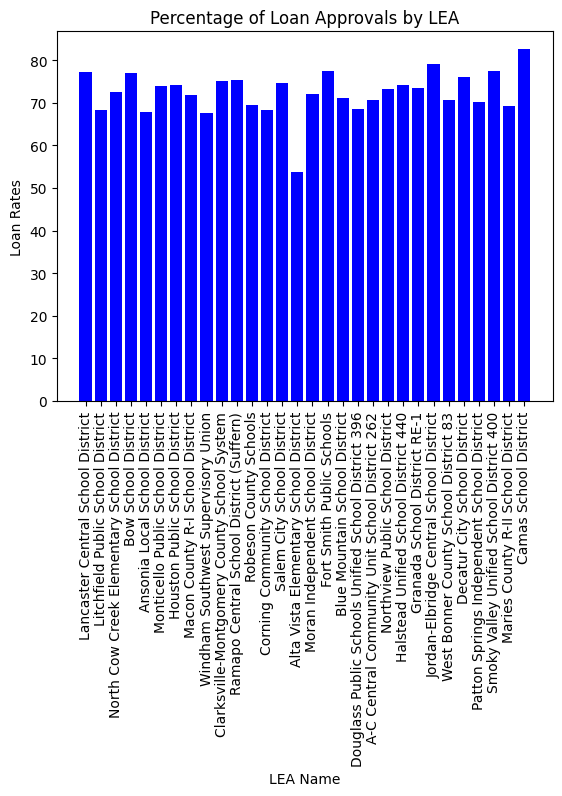

In [ ]:
# Texas
loan_Rate = [row[0] for row in approvals]
lea_name = [row[1] for row in approvals]
lea_id = [row[2] for row in approvals]
lat = [row[3] for row in approvals]
long = [row[4] for row in approvals]

# Create the plot
plt.bar(lea_name[:30], loan_Rate[:30], color='blue')

# Set the x-axis label rotation angle (in degrees)
plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()


#### Grabbing Denials for Texas

In [1]:
denials = None
# this is for executing query commands for accessing the data
denials = exec_query("WITH grf AS(\
                           SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                           FROM grf17_tracks\
                        ),\
                        hdma AS (\
                           SELECT\
                              CASE \
                              WHEN COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END) > 0\
                              THEN (COUNT(CASE WHEN action_taken IN ('3', '7') THEN 1 END) * 100.0 / COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END))::DOUBLE PRECISION\
                              ELSE 0\
                           END as percentage_accepted,\
                           (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                           FROM all_hdma_2017\
                           WHERE state_abbr = 'TX'\
                           GROUP BY census_track_num\
                        )\
                        SELECT avg(hdma.percentage_accepted) as Percent_Denied, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                        FROM hdma\
                        JOIN grf ON grf.tract = hdma.census_track_num\
                        JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                        GROUP BY grf.name_lea17, grf.leaid;")

NameError: name 'exec_query' is not defined

In [ ]:
print(denials)

#texas
loan_denial_Rate = [row[0] for row in approvals]
lea_denial_name = [row[1] for row in approvals]
lea_denial_id = [row[2] for row in approvals]

plt.bar(loan_denial_Rate[:30], lea_denial_name[:30], color='blue')
plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()



[(15.536235699704019, 'Lancaster Central School District', '3616680'), (27.24150458305388, 'Litchfield Public School District', '2718210'), (16.23218412113952, 'Oak Park and River Forest District 200', '1729280'), (19.646600421843175, 'North Cow Creek Elementary School District', '0627510'), (22.315363147505273, 'Bow School District', '3301950'), (21.37427284090668, 'Ansonia Local School District', '3904662'), (24.150204808370617, 'Monticello Public School District', '2721390'), (22.4332929493939, 'Houston Public School District', '2714280'), (24.438722301207246, 'Macon County R-I School District', '2919410'), (24.106927084837828, 'Windham Southwest Supervisory Union', '5099949'), (30.75496650471304, 'Healy Public Schools Unified School District 468', '2007080'), (20.859630542415847, 'Clarksville-Montgomery County School System', '4703030'), (17.695306506061073, 'Howell Valley R-I School District', '2915210'), (22.51164164327496, 'Ramapo Central School District (Suffern)', '3628320'), 

#### Loan Amount for Texas

In [ ]:
amounts = None
# this is for executing query commands for accessing the data
amounts = exec_query("WITH grf AS(\
                        SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                        FROM grf17_tracks\
                    ),\
                    hdma AS (\
                        SELECT\
                        sum(NULLIF(NULLIF(loan_amount_000s,''),'loan_amount_000s')::DOUBLE PRECISION) as loan_ammount,\
                        (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                        FROM all_hdma_2017\
                        WHERE state_abbr = 'TX'\
                        GROUP BY census_track_num\
                    )\
                    SELECT avg(hdma.loan_ammount) as loan_ammount, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                    FROM hdma\
                    JOIN grf ON grf.tract = hdma.census_track_num\
                    JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                    GROUP BY grf.name_lea17, grf.leaid;")


[(54998.42857142857, 'Lancaster Central School District', '3616680'), (1133872.0, 'Litchfield Public School District', '2718210'), (27940.0, 'North Cow Creek Elementary School District', '0627510'), (94320.0, 'Bow School District', '3301950'), (40224.0, 'Ansonia Local School District', '3904662'), (41164.75, 'Monticello Public School District', '2721390'), (120080.25, 'Houston Public School District', '2714280'), (202774.0, 'Macon County R-I School District', '2919410'), (66920.0, 'Windham Southwest Supervisory Union', '5099949'), (11853.916666666666, 'Clarksville-Montgomery County School System', '4703030'), (33578.333333333336, 'Ramapo Central School District (Suffern)', '3628320'), (58572.357142857145, 'Robeson County Schools', '3703930'), (823249.3333333334, 'Corning Community School District', '1908130'), (150484.5, 'Salem City School District', '3414550'), (3013.0, 'Alta Vista Elementary School District', '0602220'), (728026.0, 'Moran Independent School District', '4831320'), (19

Text(0, 0.5, 'Loan Rates')

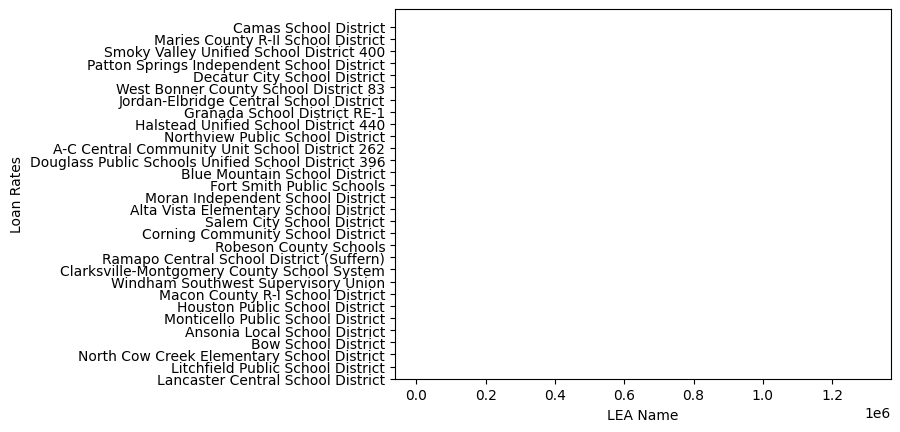

In [32]:
print(amounts)

#texas
loan_amounts = [row[0] for row in amounts]
lea_denial_name = [row[1] for row in amounts]
lea_denial_id = [row[2] for row in amounts]

plt.bar(loan_amounts[:30], lea_denial_name[:30], color='blue')
plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()


#### Grabbing Approvals for Alabama

In [33]:
approvals_al = None
# this is for executing query commands for accessing the data
approvals_al = exec_query("WITH grf AS(\
                           SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                           FROM grf17_tracks\
                        ),\
                        hdma AS (\
                           SELECT\
                              CASE \
                              WHEN COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END) > 0\
                              THEN (COUNT(CASE WHEN action_taken IN ('1', '2', '8') THEN 1 END) * 100.0 / COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END))::DOUBLE PRECISION\
                              ELSE 0\
                           END as percentage_accepted,\
                           (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                           FROM all_hdma_2017\
                           WHERE state_abbr = 'AL'\
                           GROUP BY census_track_num\
                        )\
                        SELECT avg(hdma.percentage_accepted) as Percent_Accepted, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                        FROM hdma\
                        JOIN grf ON grf.tract = hdma.census_track_num\
                        JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                        GROUP BY grf.name_lea17, grf.leaid;")


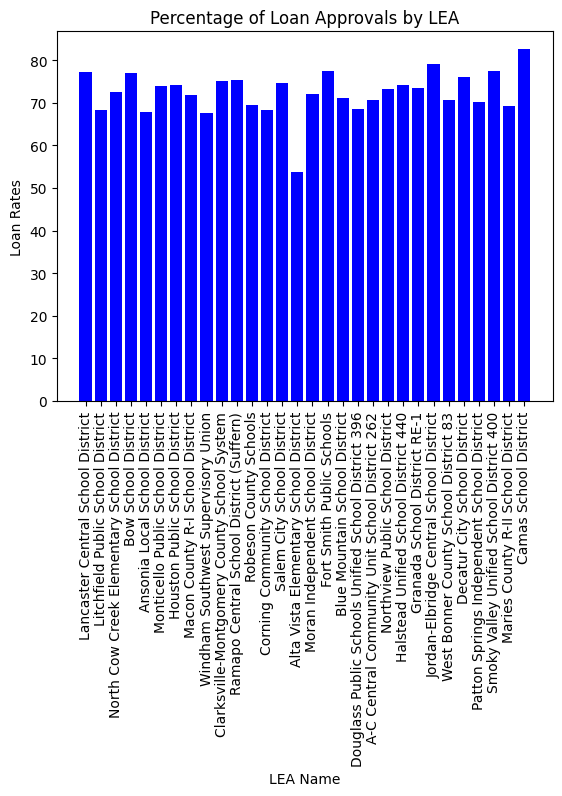

In [34]:
#print(approvals)

#texas
loan_Rate_al = [row[0] for row in approvals]
lea_name_al = [row[1] for row in approvals]
lea_id_al = [row[2] for row in approvals]

plt.bar(lea_name_al[:30], loan_Rate_al[:30], color='blue')

plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()


#### Grabbing Denials for Alabama

In [35]:
denials_al = None
# this is for executing query commands for accessing the data
denials = exec_query("WITH grf AS(\
                           SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                           FROM grf17_tracks\
                        ),\
                        hdma AS (\
                           SELECT\
                              CASE \
                              WHEN COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END) > 0\
                              THEN (COUNT(CASE WHEN action_taken IN ('3', '7') THEN 1 END) * 100.0 / COUNT(CASE WHEN action_taken IN ('1', '2', '3', '7', '8') THEN 1 END))::DOUBLE PRECISION\
                              ELSE 0\
                           END as percentage_accepted,\
                           (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                           FROM all_hdma_2017\
                           WHERE state_abbr = 'AL'\
                           GROUP BY census_track_num\
                        )\
                        SELECT avg(hdma.percentage_accepted) as Percent_Denied, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                        FROM hdma\
                        JOIN grf ON grf.tract = hdma.census_track_num\
                        JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                        GROUP BY grf.name_lea17, grf.leaid;")

KeyboardInterrupt: 

In [ ]:
print(denials_al)

#texas
loan_denial_Rate_al = [row[0] for row in approvals]
lea_denial_name_al = [row[1] for row in approvals]
lea_denial_id_al = [row[2] for row in approvals]

plt.bar(loan_denial_Rate_al[:30], lea_denial_name_al[:30], color='blue')
plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()


#### Loan Amount for Alabama

In [ ]:
amounts = None
# this is for executing query commands for accessing the data
amounts = exec_query("WITH grf AS(\
                        SELECT leaid, name_lea17, COALESCE(NULLIF(SUBSTRING(tract FROM 6),''),'0')::INTEGER::DOUBLE PRECISION / 100 as tract\
                        FROM grf17_tracks\
                    ),\
                    hdma AS (\
                        SELECT\
                        sum(NULLIF(NULLIF(loan_amount_000s,''),'loan_amount_000s')::DOUBLE PRECISION) as loan_ammount,\
                        (COALESCE(NULLIF(NULLIF(census_tract_number,'census_tract_number'),''),'0')::DOUBLE PRECISION) as census_track_num\
                        FROM all_hdma_2017\
                        WHERE state_abbr = 'AL'\
                        GROUP BY census_track_num\
                    )\
                    SELECT avg(hdma.loan_ammount) as loan_ammount, grf.name_lea17 as ISD_NAME, grf.leaid as ISD_Code, ARRAY_AGG(DISTINCT edge_geocode.lat) as lat, ARRAY_AGG(DISTINCT edge_geocode.lon) as long\
                    FROM hdma\
                    JOIN grf ON grf.tract = hdma.census_track_num\
                    JOIN edge_geocode ON edge_geocode.leaid = grf.leaid\
                    GROUP BY grf.name_lea17, grf.leaid;")

In [ ]:
print(amounts_al)

#texas
loan_amounts_al = [row[0] for row in amounts]
lea_denial_name_al = [row[1] for row in amounts]
lea_denial_id_al = [row[2] for row in amounts]

plt.bar(loan_amounts_al[:30], lea_denial_name_al[:30], color='blue')
plt.xticks(rotation=90)  # Adjust the angle as needed

plt.xlabel('LEA Name')
plt.ylabel('Loan Rates')
plt.title('Percentage of Loan Approvals by LEA')

plt.show()


# Task 4
---